In [1]:
from datasets import Dataset, DatasetDict
from PIL import Image
import os
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ColorJitter, PILToTensor, RandomHorizontalFlip, RandomPerspective, RandomRotation, RandomVerticalFlip, Compose, RandomApply
from transformers import SegformerImageProcessor
os.environ["TRANSFORMERS_NO_TF"] = "1"
import albumentations as A

def LabelMap(t):
  t[t==255] =1
  return t
    
train_pipeline = A.Compose([
    A.RandomCrop(height=320, width=320),      # Step 1: Size
    A.HorizontalFlip(p=0.5),                  # Step 2: Basic geometric
    #A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),  # Step 3: Dropout
    A.ConstrainedCoarseDropout(num_holes_range=(1, 2), hole_height_range=(0.7, 0.7),
                        hole_width_range=(0.7, 0.7), mask_indices =[1], p=0.2),
    A.OneOf([
        A.ToGray(p=1.0),
        A.ChannelDropout(p=1.0)
    ], p=0.1),
    A.RandomSunFlare(flare_roi=(0.1, 0.1, 0.9, 0.9),
                 angle_range=[0.1,0.5],
                 num_flare_circles_range=[2,8],
                 src_radius=100, src_color=(255, 255, 255),
                 p=0.4),
    A.SquareSymmetry(p=0.5),
    A.PlanckianJitter(p=0.3),
    #A.RandomShadow(p=1),  o fog
    #A.Normalize(),                            # Step 7: Normalization
])

def load_image_mask_pairs(image_dir, mask_dir):
    image_filenames = sorted(os.listdir(image_dir))
    data = []

    for fname in image_filenames:
        image_path = os.path.join(image_dir, fname)
        mask_path = os.path.join(mask_dir, fname)

        # Ensure mask exists
        if not os.path.exists(mask_path):
            continue

        data.append({
            "image": image_path,
            "segmentation_mask": mask_path
        })

    return Dataset.from_list(data)

# Define paths
train_images = "solardk_segformer/solardk_dataset_neurips_v2/train/positive"
train_masks = "solardk_segformer/solardk_dataset_neurips_v2/train/mask"
val_images = "solardk_segformer/solardk_dataset_neurips_v2/val/positive"
val_masks = "solardk_segformer/solardk_dataset_neurips_v2/val/mask"

# Load datasets
train_ds = load_image_mask_pairs(train_images, train_masks)
val_ds = load_image_mask_pairs(val_images, val_masks)

# Combine into a DatasetDict
dataset = DatasetDict({
    "train": train_ds,
    "val": val_ds
})

# Define the image processor



In [2]:
from transformers import Trainer, SegformerForSemanticSegmentation, TrainingArguments
id2label = {0: 'background', 1: 'solar_panel'}
label2id = {'background': 0, 'solar_panel': 1}

processor = SegformerImageProcessor.from_pretrained("segformer", local_files_only=True)

model = SegformerForSemanticSegmentation.from_pretrained(
    "segformer",
    local_files_only = True,
    id2label=id2label,
    label2id=label2id,
)


/leonardo/home/userexternal/acozzani/my_venv/lib/python3.11/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at segformer and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']

In [3]:
import numpy as np
def preprocess_example(example, train = False):
    image = np.array(Image.open(example['image']).convert("RGB"))
    mask = np.array(Image.open(example['segmentation_mask']).convert("L"))
    if train:
        augmented = train_pipeline(image = image, mask = mask)
        image = augmented['image']
        mask = augmented['mask']
    else:
        image = image
        mask = mask

        # Apply LabelMap to the mask
    mask_tensor = torch.tensor(mask,dtype =torch.int32)
    labeled_mask = LabelMap(mask_tensor)

    # Use the processor to resize and normalize the image and mask
    inputs = processor(images=image, segmentation_maps=labeled_mask, return_tensors="pt")

    # Remove the batch dimension added by the processor
    inputs = {k: v.squeeze() for k, v in inputs.items()}

    return inputs

# Apply the preprocess function to the datasets
processed_train_ds = dataset["train"].map(lambda example: preprocess_example(example, train = True))
processed_val_ds = dataset["val"].map(lambda example: preprocess_example(example, train = False))

Map:   0%|          | 0/721 [00:00<?, ? examples/s]

Map:   0%|          | 0/159 [00:00<?, ? examples/s]

In [4]:
import torch
from torch import nn
import evaluate
import multiprocessing

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=-2,
            reduce_labels= False,
        )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

In [5]:
from transformers import Trainer, SegformerForSemanticSegmentation, TrainingArguments

# Define training arguments
epochs = 20
lr = 0.00005
batch_size = 8

#hub_model_id = "segformer-b0-finetuned-segments-sidewalk-oct-22"

training_args = TrainingArguments(
    output_dir = "segformer_finetuning2",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="best",
    save_steps=20,
    eval_steps=20,
    logging_steps=15,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to = [],
    logging_dir ='./logs',
    #hub_model_id=hub_model_id,
    #hub_strategy="end",
)


# Define the model
# Assuming id2label and label2id are defined in a previous cell and are available
# If not, you will need to define them here or in a preceding cell
# For example:



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_train_ds, # Use the processed dataset
    eval_dataset=processed_val_ds,   # Use the processed dataset
    compute_metrics=compute_metrics,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
trainer.train()

### Inferenze su BOLO

In [ ]:
import matplotlib.pyplot as plt
from transformers import SegformerImageProcessor
from transformers import Trainer, SegformerForSemanticSegmentation, TrainingArguments
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import numpy as np

feature_extractor = SegformerImageProcessor.from_pretrained("segformer", local_files_only= True)  # o tuo config.json custom

# Carica il modello da checkpoint
model = SegformerForSemanticSegmentation.from_pretrained(
    "segformer_finetuning/checkpoint-1448",  # <-- cambia con il percorso giusto
    local_files_only=True
)



In [ ]:


class test_dataset(Dataset):
    def __init__(self,test_dir, processor = None):
        self.test_dir = test_dir
        self.test_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png','.tif')) ]
        self.processor = processor
    def __len__(self):
        return len(self.test_files)

    def __getitem__(self,idx):
        test_filepath = os.path.join(self.test_dir, self.test_files[idx])
        image = Image.open(test_filepath).convert('RGB')
        inputs = self.processor(images=image, return_tensors = 'pt')
        pixel_values = inputs['pixel_values'].squeeze(0)
        return pixel_values
        

In [ ]:
test_ds = test_dataset('dataset_bolo_class/merged/positive', processor= feature_extractor)
test_loader = DataLoader(test_ds, batch_size =4, shuffle = False)

In [ ]:
def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [ ]:
def show_preds(images, model, device):
  size = len(images)
  model.eval()
  with torch.no_grad():
      outputs = model(pixel_values=images.to(device))
      preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
  fig, axs = plt.subplots(2,size,figsize=(size * 4, 8))
  for col in range(size):
    img = images[col]
    pred = preds[col]
    img = unnormalize(img)    # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    axs[0,col].imshow(npimg)
    axs[0,col].axis('off')
    axs[1,col].imshow(pred)
    axs[1, col].axis('off')
    #plt.title(classes[labels[index]], fontsize=12)
    #plt.title(labels[index], fontsize=12)
  #plt.subplots_adjust(wspace=0.2, hspace=0.5)
  plt.show()

In [ ]:
test_iter =iter(test_loader)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

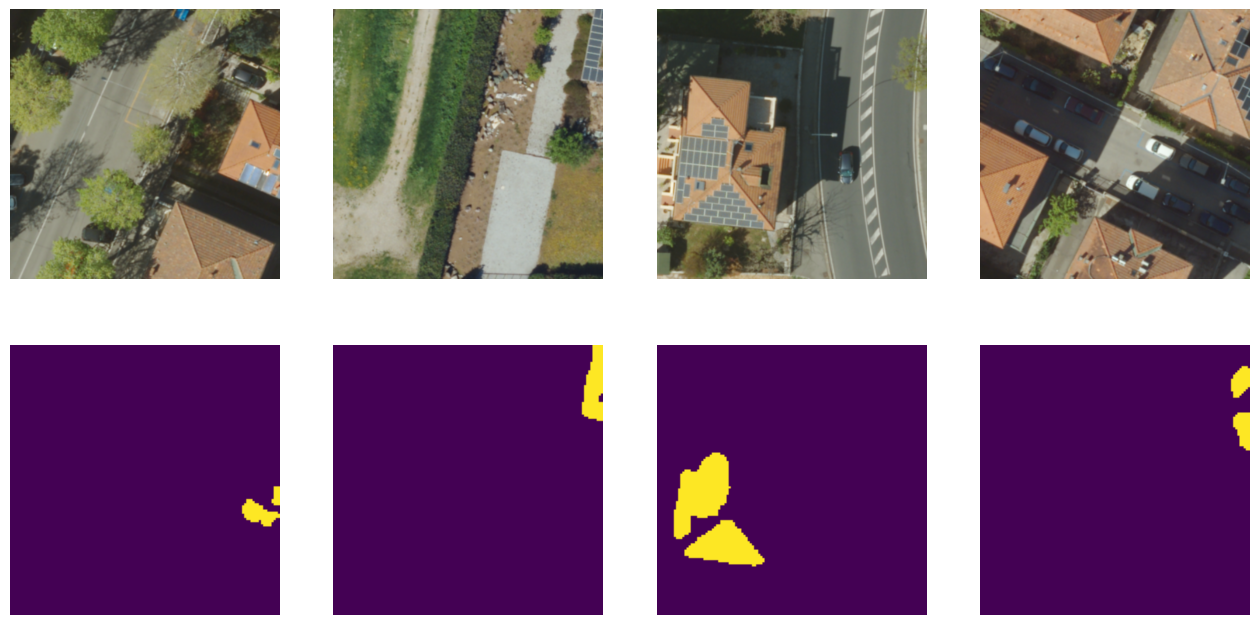

In [20]:
images = next(test_iter)
show_preds(images, model, device)